In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, List, Optional, Sequence, Tuple, Dict, Any, Literal
import numpy as np

from sklearn.metrics import adjusted_rand_score
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

## DATASETS

In [ ]:
from sktime.datasets import load_from_tsfile_to_dataframe

X_train_df, y_train = load_from_tsfile_to_dataframe("Univariate_ts/Computers/Computers_TRAIN.ts")
X_test_df, y_test = load_from_tsfile_to_dataframe("Univariate_ts/Computers/Computers_TEST.ts")

def df_to_numpy(X_df):
    # univariato: ogni cella contiene una serie
    X_np = np.array([np.array(x.iloc[0]) for _, x in X_df.iterrows()])
    return X_np  # shape (n_samples, length)

X_train = df_to_numpy(X_train_df)
X_test = df_to_numpy(X_test_df)


# X_train_df, y_train = load_from_tsfile_to_dataframe("Multivariate_ts/Cricket/Cricket_TRAIN.ts")
# X_test_df, y_test = load_from_tsfile_to_dataframe("Multivariate_ts/Cricket/Cricket_TEST.ts")

# # Conversione corretta per multivariato: (n_samples, n_channels, length)
# def df_to_3d_numpy(X_df):
#     X = []
#     for _, row in X_df.iterrows():
#         channels = [np.array(row[col]) for col in X_df.columns]
#         X.append(np.stack(channels, axis=0))  # (C, L)
#     return np.stack(X, axis=0)  # (N, C, L)

# X_train = df_to_3d_numpy(X_train_df)
# X_test = df_to_3d_numpy(X_test_df)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)



Train shape: (250, 720)
Test shape: (250, 720)


In [ ]:
DistanceFn = Callable[[np.ndarray, np.ndarray], float]  

@dataclass(frozen=True)
class CandidateInterval:
    c: int
    b: int
    e: int  

@dataclass(frozen=True)
class CandidateTest:
    c: int
    ref_idx: int    
    b: int
    e: int
    delta_name: str   
    eps: float        # threshold

@dataclass(frozen=True)
class PathEntry:
    c: int
    ref_idx: int
    b: int
    e: int
    delta_name: str
    eps: float


In [ ]:
def ensure_3d(X: np.ndarray) -> np.ndarray:
    """(n, L) -> (n, 1, L); (n, C, L) stays."""
    X = np.asarray(X)
    if X.ndim == 2:
        return X[:, None, :]
    if X.ndim == 3:
        return X
    raise ValueError(f"X must be 2D or 3D, got shape {X.shape}")

def slice_of(X3: np.ndarray, i: int, c: int, b: int, e: int) -> np.ndarray:
    return X3[i, c, b:e]

def split_by_test(X3: np.ndarray,
                  Y: Optional[np.ndarray],
                  test: CandidateTest,
                  distances: Dict[str, DistanceFn]) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray], np.ndarray]:

    c, ref_idx, b, e, dname, eps = test.c, test.ref_idx, test.b, test.e, test.delta_name, test.eps
    delta = distances[dname]
    ref_slice = slice_of(X3, ref_idx, c, b, e)

    # compute distances for all samples
    dists = np.array([delta(slice_of(X3, i, c, b, e), ref_slice) for i in range(X3.shape[0])])
    mask_true = dists <= eps

    X_true = X3[mask_true]
    X_false = X3[~mask_true]
    if Y is None:
        return X_true, None, X_false, None, mask_true
    return X_true, Y[mask_true], X_false, Y[~mask_true], mask_true


### DISTANCES

In [ ]:
def euclidean(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a); b = np.asarray(b)
    if a.shape != b.shape:
        raise ValueError("Euclidean requires same-length slices.")
    diff = a - b
    return float(np.sqrt(np.dot(diff, diff)))

def manhattan(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a); b = np.asarray(b)
    if a.shape != b.shape:
        raise ValueError("Manhattan requires same-length slices.")
    return float(np.sum(np.abs(a - b)))

def dtw(a: np.ndarray, b: np.ndarray, window: Optional[int] = None) -> float:
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    n, m = len(a), len(b)
    if n == 0 or m == 0:
        return float("inf")
    if window is None:
        window = max(n, m)
    window = max(window, abs(n - m))

    INF = 1e18
    D = np.full((n + 1, m + 1), INF, dtype=float)
    D[0, 0] = 0.0
    for i in range(1, n + 1):
        j_start = max(1, i - window)
        j_end = min(m, i + window)
        for j in range(j_start, j_end + 1):
            cost = (a[i - 1] - b[j - 1]) ** 2
            D[i, j] = cost + min(D[i - 1, j], D[i, j - 1], D[i - 1, j - 1])
    return float(np.sqrt(D[n, m]))

def corr_distance(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    if a.shape != b.shape:
        raise ValueError("Correlation distance requires same-length slices.")
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = (np.linalg.norm(a0) * np.linalg.norm(b0))
    if denom == 0:
        return 1.0
    corr = float(np.dot(a0, b0) / denom)
    return float(1.0 - corr)

def default_distances() -> Dict[str, DistanceFn]:
    return {
        "l2": euclidean,
        "l1": manhattan,
        "dtw": lambda a, b: dtw(a, b, window=None),
        "corr": corr_distance,
    }



### FP

In [ ]:
def fp_promptness(
    B_set: Sequence[int],
    next_b: int,
    X3: np.ndarray,
    Y: Optional[np.ndarray],
    *,
    window_lengths: Sequence[int] = (8, 16, 32),
    stride: int = 4,
    max_intervals: int = 64,
    rng: Optional[np.random.Generator] = None
) -> List[CandidateInterval]:
    """
    Returns candidate (channel, b, e) 
    - root starts at b=0
    - children can reuse b in B_set OR use next_b = max(E)+1
    b' ∈ B(v) U {max(E(v))+1}.
    """
    if rng is None:
        rng = np.random.default_rng(0)

    n, C, L = X3.shape
    allowed_b = sorted(set(B_set) | {next_b})
    intervals: List[CandidateInterval] = []

    for c in range(C):
        for b in allowed_b:
            if b >= L - 1:
                continue
            for w in window_lengths:
                e = b + w
                if e > L:
                    continue
                intervals.append(CandidateInterval(c=c, b=b, e=e))

    if len(intervals) > max_intervals:
        idx = rng.choice(len(intervals), size=max_intervals, replace=False)
        intervals = [intervals[i] for i in idx]

    intervals = [iv for iv in intervals if (iv.b % stride == 0)]
    if not intervals:
        intervals = [CandidateInterval(c=c, b=b, e=min(L, b + window_lengths[0]))
                     for c in range(C) for b in allowed_b if b < L - 1]

    return intervals

### FS

In [ ]:
def fs_sampling(
    X3: np.ndarray,
    Y: Optional[np.ndarray],
    intervals: Sequence[CandidateInterval],
    distances: Dict[str, DistanceFn],
    *,
    n_ref_per_interval: int = 3,
    n_eps_per_ref: int = 3,
    eps_quantiles: Sequence[float] = (0.3, 0.5, 0.7),
    delta_names: Sequence[str] = ("l2", "dtw"),
    rng: Optional[np.random.Generator] = None
) -> List[CandidateTest]:
    """
    Generate candidate tests (c, ref, eps, [b,e], delta).
    - pick reference series indices per interval
    - compute distances from all samples to ref_slice
    - choose eps as quantiles of those distances
    """
    if rng is None:
        rng = np.random.default_rng(0)

    n = X3.shape[0]
    tests: List[CandidateTest] = []

    for iv in intervals:
        ref_indices = rng.choice(n, size=min(n_ref_per_interval, n), replace=False)
        for ref_idx in ref_indices:
            for dname in delta_names:
                delta = distances[dname]
                ref_slice = slice_of(X3, ref_idx, iv.c, iv.b, iv.e)
                dists = np.array([delta(slice_of(X3, i, iv.c, iv.b, iv.e), ref_slice) for i in range(n)])
                # quantile thresholds
                for q in eps_quantiles[:n_eps_per_ref]:
                    eps = float(np.quantile(dists, q))
                    tests.append(CandidateTest(c=iv.c, ref_idx=int(ref_idx), b=iv.b, e=iv.e,
                                               delta_name=dname, eps=eps))
    return tests

 ### FO

In [ ]:
def gini_impurity(y: np.ndarray) -> float:
    if y.size == 0:
        return 0.0
    _, counts = np.unique(y, return_counts=True)
    p = counts / counts.sum()
    return float(1.0 - np.sum(p * p))

def info_gain_gini(y: np.ndarray, y_true: np.ndarray, y_false: np.ndarray) -> float:
    n = y.size
    if n == 0:
        return 0.0
    return gini_impurity(y) - (y_true.size / n) * gini_impurity(y_true) - (y_false.size / n) * gini_impurity(y_false)

def fo_optimization(
    X3: np.ndarray,
    Y: Optional[np.ndarray],
    tests: Sequence[CandidateTest],
    distances: Dict[str, DistanceFn],
    *,
    supervised: bool,
    min_leaf: int = 2
) -> Optional[CandidateTest]:
    """
    Supervised: maximize impurity reduction (Gini gain).
    Unsupervised: choose split that is most balanced
    """
    if not tests:
        return None

    best_test = None
    best_score = -np.inf
    n = X3.shape[0]

    for t in tests:
        _, Yt, _, Yf, mask_true = split_by_test(X3, Y, t, distances)
        n_true = int(mask_true.sum())
        n_false = n - n_true
        if n_true < min_leaf or n_false < min_leaf:
            continue

        if supervised:
            score = info_gain_gini(Y, Yt, Yf)
        else:
            # balance score
            p = n_true / n
            score = min(p, 1.0 - p)

        if score > best_score:
            best_score = score
            best_test = t

    return best_test


### FE

In [ ]:
def fe_stop(
    path: Sequence[PathEntry],
    X3: np.ndarray,
    Y: Optional[np.ndarray],
    *,
    max_depth: int = 10,
    min_samples_split: int = 8,
    min_samples_leaf: int = 2,
    supervised: bool = True
) -> bool:
    depth = len(path)
    n = X3.shape[0]

    if depth >= max_depth:
        return True
    if n < min_samples_split:
        return True

    if supervised and Y is not None:
        # stop if pure
        if np.unique(Y).size <= 1:
            return True


    return False


### FC

In [ ]:
def fc_leaf_distribution(
    X3: np.ndarray,
    Y: Optional[np.ndarray],
    *,
    supervised: bool,
    n_classes: Optional[int] = None,
    laplace: float = 1.0
) -> Dict[str, Any]:
    """
    What to store at a leaf
    - supervised: class distribution 
    - unsupervised: sample count 
    """
    n = X3.shape[0]
    if not supervised or Y is None:
        return {"n": int(n)}

    y = np.asarray(Y)
    classes, counts = np.unique(y, return_counts=True)

    if n_classes is None:
        probs = counts / counts.sum() if counts.sum() > 0 else counts.astype(float)
        return {"classes": classes.tolist(), "counts": counts.tolist(), "probs": probs.tolist(), "n": int(n)}

    full_counts = np.zeros(n_classes, dtype=float)
    for c, cnt in zip(classes, counts):
        full_counts[int(c)] = float(cnt)
    full_counts += laplace
    probs = full_counts / full_counts.sum()
    return {"counts": full_counts.tolist(), "probs": probs.tolist(), "n": int(n)}

# PROMPT TREE

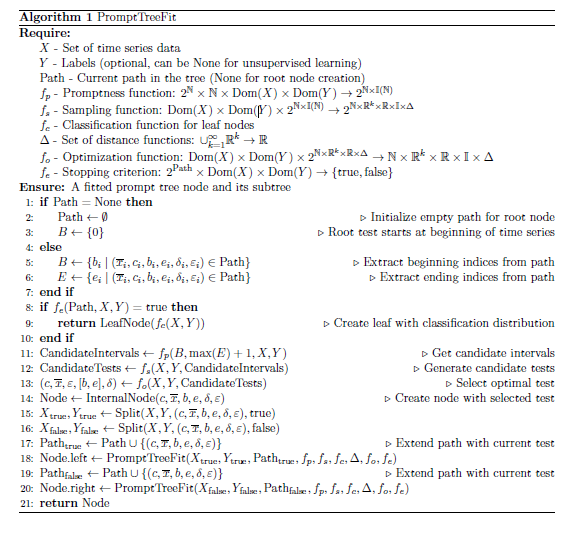

In [ ]:

class PromptTreeNode:
    def __init__(self,
                 is_leaf: bool,
                 leaf_info: Optional[Dict[str, Any]] = None,
                 test: Optional[Any] = None):
        self.is_leaf = is_leaf
        self.leaf_info = leaf_info  
        self.test = test            # (c, ref_idx, b, e, delta_name, eps)
        self.left = None            # true 
        self.right = None           # false 


class PromptDecisionTree:
    def __init__(self,
                 max_depth: int = 10,
                 min_samples_split: int = 8,
                 min_samples_leaf: int = 2,
                 supervised: bool = True,
                 window_lengths=(8, 16, 32),
                 random_state: int = 0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.supervised = supervised
        self.window_lengths = window_lengths
        self.rng = np.random.default_rng(random_state)
        self.root: Optional[PromptTreeNode] = None
        self.distances = default_distances()
        self.n_classes_ = None

    #FIT
    def fit(self, X: np.ndarray, Y: Optional[np.ndarray] = None):
        X3 = ensure_3d(X)
        
        # salvataggio training set
        self.X_train_ = X3

        if self.supervised:
            if Y is None:
                raise ValueError("Y must be provided in supervised mode.")
            Y = np.asarray(Y)
            self.classes_, Y = np.unique(Y, return_inverse=True)
            self.n_classes_ = len(self.classes_)

        self.root = self._prompt_tree_fit(
            X3=X3,
            Y=Y,
            path=[]
        )
        return self

    def _prompt_tree_fit(self,
                         X3: np.ndarray,
                         Y: Optional[np.ndarray],
                         path: List[Any]) -> PromptTreeNode:

        # Estrazione B and E from path 
        if len(path) == 0:
            B = {0}
            E = set()
        else:
            B = {p.b for p in path}
            E = {p.e for p in path}

        # Stopping criterion (fe)
        if fe_stop(
            path=path,
            X3=X3,
            Y=Y,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            supervised=self.supervised
        ):
            leaf_info = fc_leaf_distribution(
                X3=X3,
                Y=Y,
                supervised=self.supervised,
                n_classes=self.n_classes_
            )
            return PromptTreeNode(is_leaf=True, leaf_info=leaf_info)

        
        next_b = max(E) + 1 if len(E) > 0 else 0

        # FP
        intervals = fp_promptness(
            B_set=B,
            next_b=next_b,
            X3=X3,
            Y=Y,
            window_lengths=self.window_lengths,
            rng=self.rng
        )

        if len(intervals) == 0:
            leaf_info = fc_leaf_distribution(X3, Y, supervised=self.supervised, n_classes=self.n_classes_)
            return PromptTreeNode(is_leaf=True, leaf_info=leaf_info)

        # fs
        tests = fs_sampling(
            X3=X3,
            Y=Y,
            intervals=intervals,
            distances=self.distances,
            rng=self.rng
        )

        if len(tests) == 0:
            leaf_info = fc_leaf_distribution(X3, Y, supervised=self.supervised, n_classes=self.n_classes_)
            return PromptTreeNode(is_leaf=True, leaf_info=leaf_info)

        # fo
        best_test = fo_optimization(
            X3=X3,
            Y=Y,
            tests=tests,
            distances=self.distances,
            supervised=self.supervised,
            min_leaf=self.min_samples_leaf
        )

        if best_test is None:
            leaf_info = fc_leaf_distribution(X3, Y, supervised=self.supervised, n_classes=self.n_classes_)
            return PromptTreeNode(is_leaf=True, leaf_info=leaf_info)

        # internal node
        node = PromptTreeNode(is_leaf=False, test=best_test)

        X_true, Y_true, X_false, Y_false, _ = split_by_test(
            X3, Y, best_test, self.distances
        )

        path_entry = PathEntry(
            c=best_test.c,
            ref_idx=best_test.ref_idx,
            b=best_test.b,
            e=best_test.e,
            delta_name=best_test.delta_name,
            eps=best_test.eps
        )

        new_path = path + [path_entry]

        node.left = self._prompt_tree_fit(X_true, Y_true, new_path)
        node.right = self._prompt_tree_fit(X_false, Y_false, new_path)

        return node

    # PREDICT
    def _traverse(self, x3: np.ndarray, node: PromptTreeNode):
        if node.is_leaf:
            return node.leaf_info

        test = node.test
        c, ref_idx, b, e, dname, eps = (
            test.c, test.ref_idx, test.b, test.e, test.delta_name, test.eps
        )

        delta = self.distances[dname]

        ref_slice = self.X_train_[ref_idx, c, b:e]
        x_slice = x3[c, b:e]

        dist = delta(x_slice, ref_slice)

        if dist <= eps:
            return self._traverse(x3, node.left)
        else:
            return self._traverse(x3, node.right)


    def predict_proba(self, X: np.ndarray):
        if self.root is None:
            raise RuntimeError("Tree not fitted.")

        X3 = ensure_3d(X)
        probs = []

        for i in range(X3.shape[0]):
            leaf_info = self._traverse(X3[i], self.root)

            if self.supervised:
                probs.append(np.array(leaf_info["probs"]))
            else:
                probs.append(np.array([leaf_info["n"]]))

        return np.vstack(probs)


    def predict(self, X: np.ndarray):
        if not self.supervised:
            raise RuntimeError("Predict labels only available in supervised mode.")

        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    # GET PATHS
    def get_paths(self) -> List[List[PathEntry]]:
        paths = []

        def dfs(node, current_path):
            if node.is_leaf:
                paths.append(current_path.copy())
                return
            test = node.test
            entry = PathEntry(
                c=test.c,
                ref_idx=test.ref_idx,
                b=test.b,
                e=test.e,
                delta_name=test.delta_name,
                eps=test.eps
            )
            dfs(node.left, current_path + [entry])
            dfs(node.right, current_path + [entry])

        dfs(self.root, [])
        return paths

## VALUTAZIONE

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


tree = PromptDecisionTree(
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    supervised=True,
    window_lengths=(16, 32, 64),
    random_state=42
)

tree.fit(X_train, y_train_enc)


y_pred_enc = tree.predict(X_test)


y_pred = le.inverse_transform(y_pred_enc)


acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


Accuracy: 0.5925925925925926


- Accuracy: 0.48

# Random Forest

In [ ]:
VotingMode = Literal["majority", "weighted", "track_record"]

@dataclass
class _TreeMeta:
    oob_acc: float  # per weighted voting
    oob_counts: Optional[np.ndarray] = None  
    oob_totals: Optional[np.ndarray] = None  



In [ ]:

class PromptRandomForest:
    """
    - bootstrap per ogni albero
    - 3 voti: majority, weighted, track-record
    """
    def __init__(
        self,
        n_estimators: int = 50,
        voting: VotingMode = "majority",
        bootstrap: bool = True,
        max_samples: Optional[float] = 1.0,   # frazione del train per bootstrap
        random_state: int = 0,
        # Parametri base per gli alberi:
        tree_params: Optional[Dict[str, Any]] = None,
    ):
        self.n_estimators = n_estimators
        self.voting = voting
        self.bootstrap = bootstrap
        self.max_samples = max_samples
        self.random_state = random_state
        self.tree_params = tree_params or {}

        self.trees_: List[Any] = []
        self.metas_: List[_TreeMeta] = []
        self.le_: Optional[LabelEncoder] = None
        self.n_classes_: Optional[int] = None

    def _bootstrap_indices(self, n: int, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
        """Return (inbag_idx, oob_idx)."""
        if not self.bootstrap:
            inbag = np.arange(n)
            oob = np.array([], dtype=int)
            return inbag, oob

        frac = 1.0 if self.max_samples is None else float(self.max_samples)
        m = int(np.ceil(frac * n))
        inbag = rng.integers(0, n, size=m)
        mask = np.ones(n, dtype=bool)
        mask[inbag] = False
        oob = np.where(mask)[0]
        return inbag, oob

    def fit(self, X: np.ndarray, y):
        X3 = ensure_3d(X)
        y = np.asarray(y)

        # Encode labels (robusto per stringhe UCR/UEA)
        self.le_ = LabelEncoder()
        y_enc = self.le_.fit_transform(y)
        self.n_classes_ = len(self.le_.classes_)

        self.trees_.clear()
        self.metas_.clear()

        rng = np.random.default_rng(self.random_state)
        n = X3.shape[0]

        for t in range(self.n_estimators):
            inbag_idx, oob_idx = self._bootstrap_indices(n, rng)

            X_in = X3[inbag_idx]
            y_in = y_enc[inbag_idx]

            # Crea e allena un albero
            tree = PromptDecisionTree(**self.tree_params, supervised=True, random_state=int(rng.integers(0, 1_000_000_000)))
            tree.fit(X_in, y_in)

            meta = self._compute_oob_meta(tree, X3, y_enc, oob_idx)
            self.trees_.append(tree)
            self.metas_.append(meta)

        return self

    def _compute_oob_meta(self, tree, X_all: np.ndarray, y_all: np.ndarray, oob_idx: np.ndarray) -> _TreeMeta:
        """
        Calcola:
        - oob_acc per weighted voting
        - track-record stats: per classe, quanti OOB corretti / totali
        """
        if oob_idx.size == 0:
            # niente OOB: fallback neutro
            return _TreeMeta(oob_acc=1.0, oob_counts=np.zeros(self.n_classes_), oob_totals=np.ones(self.n_classes_))

        X_oob = X_all[oob_idx]
        y_oob = y_all[oob_idx]

        y_pred = tree.predict(X_oob)
        acc = float(np.mean(y_pred == y_oob)) if y_oob.size > 0 else 0.0

        # Track record per classe
        counts = np.zeros(self.n_classes_, dtype=float)
        totals = np.zeros(self.n_classes_, dtype=float)
        for yi, ypi in zip(y_oob, y_pred):
            totals[int(yi)] += 1.0
            if int(ypi) == int(yi):
                counts[int(yi)] += 1.0

        # Evita divisioni per zero dopo
        totals = np.maximum(totals, 1.0)

        return _TreeMeta(oob_acc=acc, oob_counts=counts, oob_totals=totals)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if not self.trees_:
            raise RuntimeError("Forest not fitted.")

        X3 = ensure_3d(X)
        n = X3.shape[0]
        C = self.n_classes_
        probs_agg = np.zeros((n, C), dtype=float)

        if self.voting == "majority":
            # Somma delle proba (equivale a majority su argmax se le leaf hanno proba)
            for tree in self.trees_:
                probs_agg += tree.predict_proba(X3)

            probs_agg /= len(self.trees_)
            return probs_agg

        if self.voting == "weighted":
            # Peso = oob_acc (più alto => più influenza)
            weights = np.array([m.oob_acc for m in self.metas_], dtype=float)
            # Se tutti zero, fallback 
            if np.all(weights <= 0):
                weights = np.ones_like(weights)
            wsum = float(np.sum(weights))

            for tree, w in zip(self.trees_, weights):
                probs_agg += w * tree.predict_proba(X3)

            probs_agg /= wsum
            return probs_agg

        if self.voting == "track_record":
            # Per ogni albero, pesa la proba della classe k con (correct_k / total_k) su OOB
            for tree, meta in zip(self.trees_, self.metas_):
                per_class_weight = meta.oob_counts / meta.oob_totals  # shape (C,)
                p = tree.predict_proba(X3)  # (n, C)
                probs_agg += p * per_class_weight[None, :]

            # normalizza
            row_sums = probs_agg.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1.0
            probs_agg = probs_agg / row_sums
            return probs_agg

        raise ValueError(f"Unknown voting mode: {self.voting}")

    def predict(self, X: np.ndarray):
        proba = self.predict_proba(X)
        y_pred_enc = np.argmax(proba, axis=1)
        return self.le_.inverse_transform(y_pred_enc)

    # Utilissimo per Parte 2/Unsupervised: paths di tutti gli alberi
    def get_forest_paths(self):
        return [tree.get_paths() for tree in self.trees_]

In [168]:
rf = PromptRandomForest(
    n_estimators=50,
    voting="weighted",  # weighted / majority / track_record
    random_state=42,
    tree_params=dict(
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=2,
        window_lengths=(16, 32),
    )
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("RF Accuracy :", acc)


RF Accuracy : 0.9444444444444444


In [169]:
# rf.fit(X_train, y_train)
# print(type(rf.trees_[0].root))        
# print(rf.trees_[0].root.is_leaf)     
# print(rf.trees_[0].root.test)     


In [170]:
import numpy as np
from sklearn.model_selection import train_test_split

class ConformalPromptRF:
    def __init__(self, model, alpha=0.1, random_state=42):
        self.model = model
        self.alpha = alpha
        self.random_state = random_state
        self.q_hat = None
        self.classes_ = None

    def fit(self, X, y, calibration_size=0.2):
        # Split train -> proper train + calibration (come da PDF)
        X_train, X_cal, y_train, y_cal = train_test_split(
            X, y,
            test_size=calibration_size,
            stratify=y,
            random_state=self.random_state
        )

        # Fit Random Forest sul proper training set
        self.model.fit(X_train, y_train)
        self.classes_ = self.model.le_.classes_

        # Probabilità sul calibration set
        proba_cal = self.model.predict_proba(X_cal)

        # Nonconformity score = 1 - p_true_class
        y_cal_enc = self.model.le_.transform(y_cal)
        scores = 1 - proba_cal[np.arange(len(y_cal_enc)), y_cal_enc]

        # Quantile conformal (standard split conformal)
        n = len(scores)
        q_index = int(np.ceil((n + 1) * (1 - self.alpha))) - 1
        q_index = min(q_index, n - 1)
        self.q_hat = np.sort(scores)[q_index]

        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_sets(self, X):
        """
        Restituisce i prediction sets conformal
        """
        proba = self.model.predict_proba(X)
        scores = 1 - proba
        prediction_sets = scores <= self.q_hat
        return prediction_sets

    def evaluate(self, X, y):
        """
        Metriche richieste dal PDF:
        - Miscalibration (coverage)
        - Efficiency (set size medio)
        """
        y_enc = self.model.le_.transform(y)
        pred_sets = self.predict_sets(X)

        # Coverage (1 - miscalibration)
        covered = [
            pred_sets[i, y_enc[i]]
            for i in range(len(y_enc))
        ]
        coverage = np.mean(covered)
        miscalibration = 1 - coverage

        # Efficiency = dimensione media dei prediction sets
        set_sizes = pred_sets.sum(axis=1)
        efficiency = np.mean(set_sizes)

        return {
            "coverage": coverage,
            "miscalibration": miscalibration,
            "efficiency": efficiency
        }


In [171]:
rf = PromptRandomForest(
    n_estimators=30,
    voting="weighted",
    random_state=42,
    tree_params=dict(
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=2,
        window_lengths=(16,32)
    )
)

conformal = ConformalPromptRF(rf, alpha=0.1)
conformal.fit(X_train, y_train)

# Prediction normale
y_pred = conformal.predict(X_test)

# Prediction sets conformal
pred_sets = conformal.predict_sets(X_test)

# Metriche richieste dal PDF
results = conformal.evaluate(X_test, y_test)
print(results)


{'coverage': 0.8888888888888888, 'miscalibration': 0.11111111111111116, 'efficiency': 0.9629629629629629}


## RF DISTANCES

In [172]:
class RFDistanceCalculator:
    def __init__(self, forest):
        self.forest = forest

    def _leaf_indices(self, X):
        """
        Shape: (n_samples, n_trees)
        """
        X3 = ensure_3d(X)
        n = X3.shape[0]
        T = len(self.forest.trees_)
        leaf_ids = np.zeros((n, T), dtype=int)

        for t, tree in enumerate(self.forest.trees_):
            for i in range(n):
                leaf_ids[i, t] = self._get_leaf_id(tree.root, X3[i], tree)

        return leaf_ids

    def _get_leaf_id(self, node, x, tree):
        """
        Per ottenere ID leaf
        """
        if node.is_leaf:
            return id(node)

        test = node.test
        c, ref_idx, b, e, dname, eps = (
            test.c, test.ref_idx, test.b, test.e, test.delta_name, test.eps
        )

        delta = tree.distances[dname]
        ref_slice = tree.X_train_[ref_idx, c, b:e]
        x_slice = x[c, b:e]
        dist = delta(x_slice, ref_slice)

        if dist <= eps:
            return self._get_leaf_id(node.left, x, tree)
        else:
            return self._get_leaf_id(node.right, x, tree)

    def breiman_distance(self, X):
        leaf_ids = self._leaf_indices(X)
        n, T = leaf_ids.shape
        D = np.zeros((n, n))

        for i in range(n):
            for j in range(i + 1, n):
                same_leaf = np.sum(leaf_ids[i] == leaf_ids[j])
                d = 1 - (same_leaf / T)
                D[i, j] = D[j, i] = d

        return D

    def zhu_distance(self, X):
        leaf_ids = self._leaf_indices(X)
        n, T = leaf_ids.shape
        D = np.zeros((n, n))

        for i in range(n):
            for j in range(i + 1, n):
                proximity = np.sum(leaf_ids[i] == leaf_ids[j]) / T
                d = np.sqrt(1 - proximity)
                D[i, j] = D[j, i] = d

        return D

    def ratio_rf_distance(self, X):
        leaf_ids = self._leaf_indices(X)
        n, T = leaf_ids.shape
        D = np.zeros((n, n))

        for i in range(n):
            for j in range(i + 1, n):
                matches = np.sum(leaf_ids[i] == leaf_ids[j])
                ratio = matches / T
                d = (1 - ratio) / (ratio + 1e-8)
                D[i, j] = D[j, i] = d

        return D


In [173]:
class HierarchicalRFClustering:
    def __init__(self, distance_matrix):
        self.D = distance_matrix

    def cluster(self, n_clusters):
        """
        - start: N cluster
        - merge cluster con distanza media minima
        - stop: n_clusters = numero classi
        """
        n = self.D.shape[0]
        clusters = [[i] for i in range(n)]

        while len(clusters) > n_clusters:
            min_dist = float("inf")
            pair = (0, 1)

            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = self._avg_inter_distance(clusters[i], clusters[j])
                    if dist < min_dist:
                        min_dist = dist
                        pair = (i, j)

            # merge
            i, j = pair
            clusters[i] = clusters[i] + clusters[j]
            del clusters[j]

        labels = np.zeros(n, dtype=int)
        for idx, cluster in enumerate(clusters):
            for sample in cluster:
                labels[sample] = idx

        return labels

    def _avg_inter_distance(self, c1, c2):
        dists = [self.D[i, j] for i in c1 for j in c2]
        return np.mean(dists)


In [174]:
class ClusteringEvaluator:
    @staticmethod
    def intra_cluster_distance(D, labels):
        intra = []
        for k in np.unique(labels):
            idx = np.where(labels == k)[0]
            if len(idx) > 1:
                intra.append(np.mean([D[i, j] for i in idx for j in idx if i != j]))
        return np.mean(intra)

    @staticmethod
    def inter_cluster_distance(D, labels):
        inter = []
        unique = np.unique(labels)
        for i in range(len(unique)):
            for j in range(i + 1, len(unique)):
                c1 = np.where(labels == unique[i])[0]
                c2 = np.where(labels == unique[j])[0]
                inter.append(np.mean([D[a, b] for a in c1 for b in c2]))
        return np.mean(inter)

    @staticmethod
    def purity(y_true, y_pred):
        total = 0
        for cluster in np.unique(y_pred):
            idx = np.where(y_pred == cluster)[0]
            if len(idx) == 0:
                continue
            labels = y_true[idx]
            most_common = Counter(labels).most_common(1)[0][1]
            total += most_common
        return total / len(y_true)

    @staticmethod
    def entropy(y_true, y_pred):
        from math import log
        n = len(y_true)
        entropy_total = 0
        for cluster in np.unique(y_pred):
            idx = np.where(y_pred == cluster)[0]
            labels = y_true[idx]
            counts = Counter(labels)
            cluster_entropy = 0
            for c in counts.values():
                p = c / len(idx)
                cluster_entropy -= p * log(p + 1e-10)
            entropy_total += (len(idx) / n) * cluster_entropy
        return entropy_total

    @staticmethod
    def ari(y_true, y_pred):
        return adjusted_rand_score(y_true, y_pred)


In [178]:
from math import log
class PromptIsolationForest:
    def __init__(
        self,
        n_estimators=50,
        max_samples=256,
        max_depth=10,
        random_state=42,
        tree_params=None
    ):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.random_state = random_state
        self.tree_params = tree_params or {}
        self.trees_ = []
        self.sample_sizes_ = []
        self.rng = np.random.default_rng(random_state)

    def fit(self, X):
        X3 = ensure_3d(X)
        n = X3.shape[0]
        self.trees_ = []
        self.sample_sizes_ = []

        for i in range(self.n_estimators):
            # Subsampling (come Isolation Forest classica)
            sample_size = min(self.max_samples, n)
            idx = self.rng.choice(n, size=sample_size, replace=False)

            X_sub = X3[idx]

            # Albero UNSUPERVISED (Y=None)
            tree = PromptDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=2,
                min_samples_leaf=1,
                supervised=False,
                **self.tree_params,
                random_state=int(self.rng.integers(0, 1e9))
            )

            tree.fit(X_sub, Y=None)

            self.trees_.append(tree)
            self.sample_sizes_.append(sample_size)

        return self

    def _path_length(self, x, node, tree, current_depth=0):
        if node.is_leaf:
            n = node.leaf_info.get("n", 1)
            return current_depth + self._c_factor(n)

        test = node.test
        c, ref_idx, b, e, dname, eps = (
            test.c, test.ref_idx, test.b, test.e, test.delta_name, test.eps
        )

        delta = tree.distances[dname]
        ref_slice = tree.X_train_[ref_idx, c, b:e]
        x_slice = x[c, b:e]
        dist = delta(x_slice, ref_slice)

        if dist <= eps:
            return self._path_length(x, node.left, tree, current_depth + 1)
        else:
            return self._path_length(x, node.right, tree, current_depth + 1)

    def _c_factor(self, n):
        """Expected path length normalization (Isolation Forest formula)"""
        if n <= 1:
            return 0
        return 2 * (log(n - 1) + 0.5772156649) - (2 * (n - 1) / n)

    def anomaly_score(self, X):
        X3 = ensure_3d(X)
        scores = []

        for x in X3:
            path_lengths = [
                self._path_length(x, tree.root, tree)
                for tree in self.trees_
            ]

            avg_path_length = np.mean(path_lengths)
            c_n = self._c_factor(self.max_samples)

            # Isolation Forest anomaly score
            score = 2 ** (-avg_path_length / c_n)
            scores.append(score)

        return np.array(scores)

    def predict(self, X, threshold=None):
        """
        Output:
        -1 = anomaly
         1 = normal
        """
        scores = self.anomaly_score(X)

        if threshold is None:
            threshold = np.percentile(scores, 95)  

        labels = np.where(scores >= threshold, -1, 1)
        return labels


In [177]:
iso_forest = PromptIsolationForest(
    n_estimators=30,
    max_samples=128,
    max_depth=10,
    tree_params=dict(
        window_lengths=(8, 16, 32)
    )
)

iso_forest.fit(X_train)
scores = iso_forest.anomaly_score(X_train)
print("Anomaly scores shape:", scores.shape)
labels_anomaly = iso_forest.predict(X_train)
print("Anomalies detected:", np.sum(labels_anomaly == -1))


NameError: name 'log' is not defined

In [ ]:
# Unsupervised
rf = PromptRandomForest(
    n_estimators=30,
    voting="majority",
    random_state=42,
    tree_params=dict(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        window_lengths=(16, 32)
    )
)

rf.fit(X_train, y_train)  

# RF Distances
rf_dist = RFDistanceCalculator(rf_unsup)

D_breiman = rf_dist.breiman_distance(X_train)
D_zhu = rf_dist.zhu_distance(X_train)
D_ratio = rf_dist.ratio_rf_distance(X_train)

# Clustering 
n_clusters = len(np.unique(y_train))

clusterer_b = HierarchicalRFClustering(D_breiman)
labels_b = clusterer_b.cluster(n_clusters)

clusterer_z = HierarchicalRFClustering(D_zhu)
labels_z = clusterer_z.cluster(n_clusters)

clusterer_r = HierarchicalRFClustering(D_ratio)
labels_r = clusterer_r.cluster(n_clusters)

# Evaluation 
eval = ClusteringEvaluator()

print("Breiman Intra:", eval.intra_cluster_distance(D_breiman, labels_b))
print("Breiman Inter:", eval.inter_cluster_distance(D_breiman, labels_b))
print("Breiman Purity:", eval.purity(y_train, labels_b))
print("Breiman ARI:", eval.ari(y_train, labels_b))

print("Zhu ARI:", eval.ari(y_train, labels_z))
print("RatioRF ARI:", eval.ari(y_train, labels_r))


OverflowError: Python int too large to convert to C long

# VISUALIZZAZIONI

In [ ]:
import matplotlib.pyplot as plt

def plot_samples_per_class(X, y, n_per_class=3):
    classes = np.unique(y)
    plt.figure(figsize=(12, 6))

    for i, cls in enumerate(classes):
        idx = np.where(y == cls)[0][:n_per_class]
        for j, k in enumerate(idx):
            plt.subplot(len(classes), n_per_class, i*n_per_class + j + 1)
            plt.plot(X[k])
            plt.title(f"{cls}")
            plt.tight_layout()

    plt.suptitle("TS samples per class")
    plt.show()

plot_samples_per_class(X_train, y_train)


In [ ]:
def forest_tree_depths(forest):
    depths = []
    
    def get_depth(node):
        if node.is_leaf:
            return 1
        return 1 + max(get_depth(node.left), get_depth(node.right))

    for tree in forest.trees_:
        depths.append(get_depth(tree.root))

    return depths

depths = forest_tree_depths(rf)

plt.figure(figsize=(6,4))
plt.hist(depths, bins=10)
plt.title("Distribution of tree depths")
plt.xlabel("Depth")
plt.ylabel("Frequency")
plt.show()


In [ ]:
voting_methods = ["majority", "weighted", "track_record"]
results = {}

for v in voting_methods:
    rf = PromptRandomForest(
        n_estimators=20,
        voting=v,
        random_state=42,
        tree_params=dict(
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            window_lengths=(8, 16, 32)
        )
    )
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[v] = acc

print("Voting comparison:", results)

plt.bar(results.keys(), results.values())
plt.title("Accuracy comparison: voting methods")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
alphas = [0.05, 0.1, 0.2]
coverages = []
efficiencies = []

for a in alphas:
    conformal = ConformalPromptRF(rf, alpha=a)
    conformal.fit(X_train, y_train)
    res = conformal.evaluate(X_test, y_test)
    
    coverages.append(res["coverage"])
    efficiencies.append(res["efficiency"])

plt.plot(alphas, coverages, marker="o", label="Coverage")
plt.plot(alphas, efficiencies, marker="s", label="Efficiency")
plt.xlabel("Alpha")
plt.title("Conformal analysis")
plt.legend()
plt.show()
